# NLP : Classifiaction des fake news via les ML et Deep learning
L'objetif est de construire un système d'apprentissage pour identifier les articles de presse non fiables. Il s'agit ici d'un problème NLP où la tâche est de classifier les Fake News dans un article. Ce notebook est composé de différentes étapes nécessaires:
- identification des fakes news
- le prétraitement des données  
- l'expérimentation du modèle et l'évaluation des résultats.

In [143]:
# Importing Libraries
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow import keras
from keras import models    

from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

[nltk_data] Downloading package stopwords to /Users/vw12/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
# Reading data from csv
df_train = pd.read_csv("/Users/vw12/Desktop/API_Scrapping/Classification_fake/fake-news/train.csv")
df_test  = pd.read_csv("/Users/vw12/Desktop/API_Scrapping/Classification_fake/fake-news/test.csv")
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [93]:
df_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [94]:
# Displaying rows and columns in dataset
print("Il y a  {} lignes et  {} colonnes pour le training.".format(df_train.shape[0],df_train.shape[1]))
print("Il y a  {} lignes et  {} colonnes pour le testing.".format(df_test.shape[0],df_test.shape[1]))

Il y a  20800 lignes et  5 colonnes pour le training.
Il y a  5200 lignes et  4 colonnes pour le testing.


**Checking Null Values**

In [95]:
# Recherche des values manquantes dans training data.
df_train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [96]:
# Recherche des values manquantes dans testing data.
df_test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [101]:
# Remplacer les valeurs nan dans un ensemble de données par l'espace vide
def handle_nan(train_data,test_data):
    '''Input: Data to the function containing Nan values.
       Output : Cleaned data containing no Nan values.
       Function: Cleaning Nan values.
     '''
    train = train_data.fillna(" ")
    test  = test_data.fillna(" ")
    return train,test



In [103]:
train,test = handle_nan(df_train,df_test)
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [104]:
# Création de variables qui fusionne les colonnes  "title" et "author"
train["merged"] = train["title"]+" "+train["author"]
test["merged"]  = test["title"]+" "+test["author"]

In [105]:
# Séparation des features des cibles
X = train.drop(columns=['label'],axis=1)
y = train['label']

In [106]:
X.head()

,id,title,author,text,merged
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...


In [107]:
# Creating One-Hot Representations
messages = X.copy()
messages.reset_index(inplace=True)
messages_test = test.copy()
messages_test.reset_index(inplace=True)

In [108]:
messages.head()

,index,id,title,author,text,merged
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Consortiumne...
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...


# Data Preprocessing
**Les étapes de préprocessing des données sont les suivantes:** 
- 1. D'abord, toutes les séquences, à l'exception des caractères anglaises, sont supprimées de la chaîne.
- 2. Pour éviter de fausses prédictions ou ambiguité avec les majuscules et les minuscules toutes les caractères sont conserver en minuscules.
- 3. Ensuite toutes la phrases sont Tokeniser en mots ou expressions
- 4. Pour faciliter le preprocessing,  le stemming est appliqué aux mots tokenisés.
- 5. A la fin les mots sont jointent et stockés dans un corpus .



In [109]:
#  data preprocessing de la colonne 'title'
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def perform_preprocess(data):
    '''Input: Data à etre traité
       Output: data traité
    '''
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ',data['merged'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    


In [110]:
train_corpus = perform_preprocess(messages)
test_corpus  = perform_preprocess(messages_test)
train_corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [111]:
test_corpus[1]

'russian warship readi strike terrorist near aleppo'

**Le code ci-dessous convertit les mots prétraités en vecteurs à un vecteur one-hot taille de vocabulaire = 5000. Ceci est fait pour obtenir une matrice numérique de caractéristiques**

In [112]:
# Converting to one-hot repr.
vocab_size = 5000
one_hot_train = [one_hot(word,vocab_size) for word in train_corpus]
one_hot_test  = [one_hot(word,vocab_size) for word in test_corpus]

In [113]:
one_hot_test[1]

[1559, 3748, 3863, 4037, 2729, 1222, 4982]

**Le code ci-dessous crée une couche embledding qui applique un "pré" remplissage aux caractéristiques codées via one hot  avec une longueur = 20. Le remplissage est appliqué de manière à ce que la longueur de chaque séquence dans l'ensemble de données soit la même.**

In [114]:
# Embedding Representation 
sent_length = 20
embedd_docs_train = pad_sequences(one_hot_train,padding='pre',maxlen=sent_length)
embedd_docs_test  = pad_sequences(one_hot_test,padding='pre',maxlen=sent_length)
print(embedd_docs_train)

[[   0    0    0 ... 3134 2859  454]
 [   0    0    0 ... 1758 2610 3492]
 [   0    0    0 ... 3501 2750  875]
 ...
 [   0    0    0 ...  794 2183 3346]
 [   0    0    0 ... 2783 3091 1819]
 [   0    0    0 ... 2549  445 2274]]


In [115]:
embedd_docs_test.shape, print(embedd_docs_test)

[[   0    0    0 ... 3623  445  237]
 [   0    0    0 ... 2729 1222 4982]
 [   0    0    0 ... 2705 3171 1776]
 ...
 [   0    0    0 ... 3623 2303 4509]
 [   0    0    0 ... 1559 2228 1320]
 [   0    0    0 ... 3623 4440 3084]]


((5200, 20), None)

In [116]:
# Conversion du Embedding representation. à un tableau array
x_final = np.array(embedd_docs_train)
y_final = np.array(y)
x_test_final = np.array(embedd_docs_test)

In [117]:
# Dimensions of prev. array repr.
x_final.shape,y_final.shape,x_test_final.shape

((20800, 20), (20800,), (5200, 20))

**Dividing the dataset into training,validation and testing data (ratio: 80/10/10) using train_test_split technique.**

In [118]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42, stratify = y_final)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
x_test_final == x_test_final

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [59]:
x_test_final.shape

(5200, 20)

In [119]:
def accuracy(pred,verite):
    return ((pred==verite).mean())

# Creating Models
**In this phase, several models are created and evaluated against various metrics shown using classification report.**

**1. Logistic Regresssion**

In [121]:
model_1 = LogisticRegression(max_iter=900)
model_1.fit(X_train,Y_train)
pred_1 = model_1.predict(x_test)
cr1    = classification_report(y_test,pred_1)
print(cr1)

              precision    recall  f1-score   support

           0       0.71      0.76      0.74      1039
           1       0.74      0.69      0.72      1041

    accuracy                           0.73      2080
   macro avg       0.73      0.73      0.73      2080
weighted avg       0.73      0.73      0.73      2080



In [122]:
accuracy(pred_1,y_test)

0.7269230769230769

**2. Naive Bayes**

In [123]:
model_2 = MultinomialNB()
model_2.fit(X_train,Y_train)
pred_2 = model_2.predict(x_test)
cr2    = classification_report(y_test,pred_2)
print(cr2)

              precision    recall  f1-score   support

           0       0.70      0.60      0.65      1039
           1       0.65      0.74      0.69      1041

    accuracy                           0.67      2080
   macro avg       0.67      0.67      0.67      2080
weighted avg       0.67      0.67      0.67      2080



In [124]:
accuracy(pred_2,y_test)

0.6711538461538461

**3. Decision Trees**

In [125]:
model_3 = DecisionTreeClassifier()
model_3.fit(X_train,Y_train)
pred_3 = model_3.predict(x_test)
cr3    = classification_report(y_test,pred_3)
print(cr3)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1039
           1       0.89      0.89      0.89      1041

    accuracy                           0.89      2080
   macro avg       0.89      0.89      0.89      2080
weighted avg       0.89      0.89      0.89      2080



In [126]:
accuracy(pred_3,y_test)

0.8875

**4. Random Forest**

In [127]:
model_4 = RandomForestClassifier()
model_4.fit(X_train,Y_train)
pred_4 = model_4.predict(x_test)
cr4    = classification_report(y_test,pred_4)
print(cr4)

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1039
           1       0.87      0.96      0.91      1041

    accuracy                           0.91      2080
   macro avg       0.91      0.91      0.91      2080
weighted avg       0.91      0.91      0.91      2080



In [128]:
accuracy(pred_4,y_test)

0.9100961538461538

**5. XGBOOST**

In [129]:
model_5 = XGBClassifier()
model_5.fit(X_train,Y_train)
pred_5 = model_5.predict(x_test)
cr5    = classification_report(y_test,pred_5)
print(cr5)

/Users/vw12/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1039
           1       0.98      0.99      0.98      1041

    accuracy                           0.98      2080
   macro avg       0.98      0.98      0.98      2080
weighted avg       0.98      0.98      0.98      2080



In [130]:
accuracy(pred_5,y_test)

0.9846153846153847

**6.Catboost**

In [131]:
model_6 = CatBoostClassifier(iterations=200)
model_6.fit(X_train,Y_train)
pred_6 = model_5.predict(x_test)
cr6    = classification_report(y_test,pred_5)
print(cr6)

Learning rate set to 0.150531
0:	learn: 0.5909504	total: 23.2ms	remaining: 4.61s
1:	learn: 0.5224908	total: 37.3ms	remaining: 3.7s
2:	learn: 0.4794414	total: 51.3ms	remaining: 3.37s
3:	learn: 0.4405944	total: 65.3ms	remaining: 3.2s
4:	learn: 0.4192496	total: 79.1ms	remaining: 3.08s
5:	learn: 0.3916212	total: 93.2ms	remaining: 3.01s
6:	learn: 0.3828905	total: 108ms	remaining: 2.96s
7:	learn: 0.3725635	total: 122ms	remaining: 2.92s
8:	learn: 0.3518537	total: 136ms	remaining: 2.88s
9:	learn: 0.3434033	total: 150ms	remaining: 2.84s
10:	learn: 0.3367218	total: 164ms	remaining: 2.81s
11:	learn: 0.3303275	total: 177ms	remaining: 2.78s
12:	learn: 0.3233883	total: 192ms	remaining: 2.76s
13:	learn: 0.3174861	total: 210ms	remaining: 2.79s
14:	learn: 0.3123141	total: 227ms	remaining: 2.81s
15:	learn: 0.3065631	total: 243ms	remaining: 2.79s
16:	learn: 0.2991320	total: 257ms	remaining: 2.76s
17:	learn: 0.2911423	total: 270ms	remaining: 2.73s
18:	learn: 0.2877549	total: 284ms	remaining: 2.71s
19:	lea

163:	learn: 0.0755363	total: 2.77s	remaining: 608ms
164:	learn: 0.0748267	total: 2.8s	remaining: 594ms
165:	learn: 0.0743317	total: 2.82s	remaining: 578ms
166:	learn: 0.0738719	total: 2.84s	remaining: 562ms
167:	learn: 0.0733567	total: 2.87s	remaining: 546ms
168:	learn: 0.0729171	total: 2.89s	remaining: 531ms
169:	learn: 0.0726992	total: 2.93s	remaining: 517ms
170:	learn: 0.0724125	total: 2.96s	remaining: 502ms
171:	learn: 0.0719369	total: 2.98s	remaining: 486ms
172:	learn: 0.0715359	total: 3s	remaining: 469ms
173:	learn: 0.0710075	total: 3.02s	remaining: 452ms
174:	learn: 0.0704084	total: 3.04s	remaining: 435ms
175:	learn: 0.0700266	total: 3.06s	remaining: 418ms
176:	learn: 0.0697832	total: 3.08s	remaining: 401ms
177:	learn: 0.0695567	total: 3.1s	remaining: 384ms
178:	learn: 0.0692029	total: 3.13s	remaining: 367ms
179:	learn: 0.0689097	total: 3.15s	remaining: 350ms
180:	learn: 0.0682604	total: 3.16s	remaining: 332ms
181:	learn: 0.0679888	total: 3.18s	remaining: 315ms
182:	learn: 0.067

In [132]:
accuracy(pred_6,y_test)

0.9846153846153847

## SVM

In [133]:
model_7=LinearSVC()
model_7.fit(x_train,y_train)
pred_7 = model_7.predict(x_test)
cr7    = classification_report(y_test,pred_7)
print(cr7)

              precision    recall  f1-score   support

           0       0.69      0.02      0.03      1039
           1       0.50      0.99      0.67      1041

    accuracy                           0.51      2080
   macro avg       0.60      0.50      0.35      2080
weighted avg       0.60      0.51      0.35      2080



/Users/vw12/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [135]:
accuracy(pred_7,y_test)

0.5052884615384615

**7. Le modèle LSTM**
Dans ce modèle
- 1.) Les valeurs du vecteur feature embedding = 40 qui sont des vecteurs de features cibles pour la couche embledding. 
- 2.) Une couche LSTM avec 100 nœuds est utilisée. 
- 3) Une couche dense avec 1 neurone et une fonction d'activation sigmoïde est utilisée car il s'agit d'un problème de classification binaire. 
- 4) La technique de Dropout est utilisée pour éviter la surcharge et l'optimiseur Adam est utilisé pour optimiser la fonction de perte.



In [138]:
# Création du modèle  LSTM Model pour la prediction
embedding_feature_vector = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [139]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss',mode='min', verbose=0,patience=50,restore_best_weights=True)

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=2)
save= ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)


training=model.fit(X_train, Y_train,epochs=100,verbose=0,batch_size=64,
                   validation_data=(x_valid,y_valid),callbacks=[early_stop,save])

#model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64)

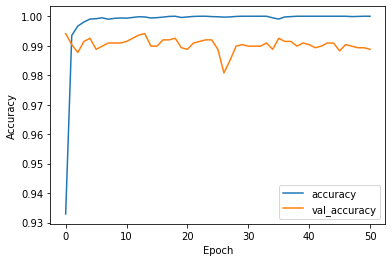

In [140]:
import matplotlib.pyplot as plt
plt.plot(training.history['accuracy'], label='accuracy')
plt.plot(training.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0., 1])
plt.legend(loc='lower right')
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [145]:
# load the saved model

#modele = load_model('best_model.h5')
loss,acc = model.evaluate(x_test,  y_test, verbose=1)
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)

print(" loss train accuracy: {:5.2f}%".format(100*train_loss))
print(" train accuracy: {:5.2f}%".format(100*train_acc))
print("**"*30)
print(" loss test  accuracy: {:5.2f}%".format(100*loss))
print(" test  accuracy: {:5.2f}%".format(100*acc))


65/65 [==============================] - 1s 7ms/step - loss: 0.0310 - accuracy: 0.9899
 loss train accuracy:  1.89%
 train accuracy: 99.44%
************************************************************
 loss test  accuracy:  3.10%
 test  accuracy: 98.99%


In [146]:
predictions = model.predict_classes(x_test)
cr = classification_report(y_test,predictions)
print(cr)

/Users/vw12/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1039
           1       0.99      0.99      0.99      1041

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080



## le modèle de BI-LSTM : bidirectionnel

In [148]:
# Building an LSTM Model with an embedding layer #
model1 = Sequential()
model1.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
model1.add(Dropout(0.3))
model1.add(Bidirectional(LSTM(100)))  # 100 memory cells / Neurons 
model1.add(Dropout(0.3))
model1.add(Dense(64,activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))  # sigmoid will help in classifying news as fake or real
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                12864     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [149]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss',mode='min', verbose=0,patience=50,restore_best_weights=True)

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=2)
save= ModelCheckpoint('best_model_bi_direction.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)


training=model1.fit(X_train, Y_train,epochs=100,verbose=0,batch_size=64,
                   validation_data=(x_valid,y_valid),callbacks=[early_stop,save])

#model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64)

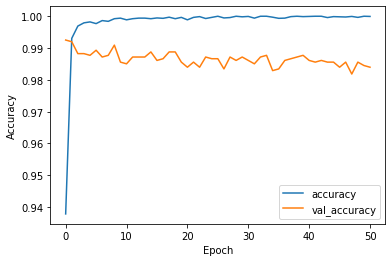

In [151]:
import matplotlib.pyplot as plt
plt.plot(training.history['accuracy'], label='accuracy')
plt.plot(training.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0., 1])
plt.legend(loc='lower right')
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [150]:
# load the saved model

#modele = load_model('best_model.h5')
loss,acc = model1.evaluate(x_test,  y_test, verbose=1)
train_loss, train_acc = model1.evaluate(X_train, Y_train, verbose=0)

print(" loss train accuracy: {:5.2f}%".format(100*train_loss))
print(" train accuracy: {:5.2f}%".format(100*train_acc))
print("**"*30)
print(" loss test  accuracy: {:5.2f}%".format(100*loss))
print(" test  accuracy: {:5.2f}%".format(100*acc))


65/65 [==============================] - 2s 9ms/step - loss: 0.0357 - accuracy: 0.9885
 loss train accuracy:  1.40%
 train accuracy: 99.60%
************************************************************
 loss test  accuracy:  3.57%
 test  accuracy: 98.85%


In [153]:
predictions_bi = model1.predict_classes(x_test)
cr8 = classification_report(y_test,predictions_bi)
print(cr8)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1039
           1       0.99      0.99      0.99      1041

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080



# Evaluation of Models

**Tabulating the results of various implemented models.**

In [157]:
score_1 = accuracy_score(y_test,pred_1)
score_2 = accuracy_score(y_test,pred_2)
score_3 = accuracy_score(y_test,pred_3)
score_4 = accuracy_score(y_test,pred_4)
score_5 = accuracy_score(y_test,pred_5)
score_6 = accuracy_score(y_test,pred_6)
score_7 = accuracy_score(y_test,predictions)
score_8 = accuracy_score(y_test,predictions_bi)
results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Decision Tree",score_3],
                       ["Random Forest",score_4],["XGBOOST",score_5],["CatBoost",score_6],["LSTM",score_7],["BI-LSTM",score_8]],columns=["Model","Accuracy"])
results

,Model,Accuracy
0,Logistic Regression,0.726923
1,Naive Bayes,0.671154
2,Decision Tree,0.887500
3,Random Forest,0.910096
4,XGBOOST,0.984615
5,CatBoost,0.984615
6,LSTM,0.989904
7,BI-LSTM,0.988462


**Discussion : A partir des résultats ci-dessus, il apparaît que le modèle LSTM donne la plus grande précision parmi les différents modèles. Par conséquent, il est sélectionné comme le modèle final pour faire des prédictions sur les données de test finales.**

**Predictions on Testing Data**

In [155]:
# Making Predictions on test data
predictions_test = pd.DataFrame(model.predict_classes(x_test_final))
test_id = pd.DataFrame(test["id"])
submission = pd.concat([test_id,predictions_test],axis=1)
submission.columns = ["id","label"]
submission.to_csv("Submission.csv",index=False)

/Users/vw12/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [156]:
submission.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
